1) mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2) install libraries

In [3]:
!pip install torch transformers datasets scikit-learn accelerate sentencepiece protobuf rouge-score nltk matplotlib

3) import libraries needed

In [4]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed
from torch.amp import autocast, GradScaler
import string
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

4) device setup

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using: {device}")

Device using: cuda


5) dataset paths

In [6]:
judgment_dir = "/content/drive/MyDrive/talqs dataset/qa dataset/input judgements"
qa_dir = "/content/drive/MyDrive/talqs dataset/qa dataset/qa pairs"

print("Question - Answering model dataset")
print("Total input judgement files(text):", len(os.listdir(judgment_dir)))
print("Total qa pairs files(json):", len(os.listdir(qa_dir)))

Question - Answering model dataset
Total input judgement files(text): 1100
Total qa pairs files(json): 1100


In [8]:
examples = []
file_list = [f for f in os.listdir(qa_dir) if f.endswith('.json')]

def process_file(filename):
    file_id = filename.replace(".json", "")
    qa_path = os.path.join(qa_dir, filename)
    txt_path = os.path.join(judgment_dir, f"{file_id}.txt")

    if not os.path.exists(txt_path):
        return []

    with open(txt_path, 'r', encoding='utf-8') as f:
        context = f.read()

    with open(qa_path, 'r', encoding='utf-8') as f:
        qa_data = json.load(f)

    local_examples = []
    for qa in qa_data.get("qas", []):
        question = qa.get("question", "").strip()
        answer = qa.get("answer", "").strip()
        if question and answer:
            input_text = f"question: {question} context: {context}"
            local_examples.append({
                "input_text": input_text,
                "target_text": answer
            })

    return local_examples

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(process_file, filename) for filename in file_list]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Loading QA pairs"):
        examples.extend(future.result())

Loading QA pairs: 100%|██████████| 1100/1100 [00:42<00:00, 26.08it/s]


7) data splitting

In [9]:
train_data, val_data = train_test_split(examples, test_size=0.3, random_state=42)

8) start fine tuning

In [10]:
model_name = "t5-base"
# "t5-base" OR "t5-large" OR "t5-3b" OR "led model"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [15]:
checkpoint_dir = "/content/drive/MyDrive/talqs dataset/qa dataset"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pt")

start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Loaded checkpoint from epoch {start_epoch}")
else:
    print("No checkpoint found")

No checkpoint found


10) dataset class

In [16]:
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_encoding = tokenizer(
            item["input_text"],
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = tokenizer(
            item["target_text"],
            max_length=64,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": input_encoding["input_ids"].squeeze(0),
            "attention_mask": input_encoding["attention_mask"].squeeze(0),
            "labels": target_encoding["input_ids"].squeeze(0)
        }

11)

In [17]:
train_dataset = QADataset(train_data)
val_dataset = QADataset(val_data)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=2, pin_memory=True)

In [19]:
def save_checkpoint(epoch, model, optimizer, checkpoint_path):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [20]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5
accumulation_steps = 8

In [21]:
train_losses = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.3f}\n")

    save_checkpoint(epoch, model, optimizer, checkpoint_path)

final_model_path = "/content/drive/MyDrive/talqs dataset/qa dataset/model.pth"
torch.save(model.state_dict(), final_model_path)
print(f"\nModel saved to: {final_model_path}")

Epoch 1/5: 100%|██████████| 3804/3804 [39:33<00:00,  1.60it/s, loss=0.464]


Training Loss: 0.953

Checkpoint saved at epoch 1


Epoch 2/5:  69%|██████▊   | 2615/3804 [27:12<12:22,  1.60it/s, loss=0.87]


KeyboardInterrupt: 

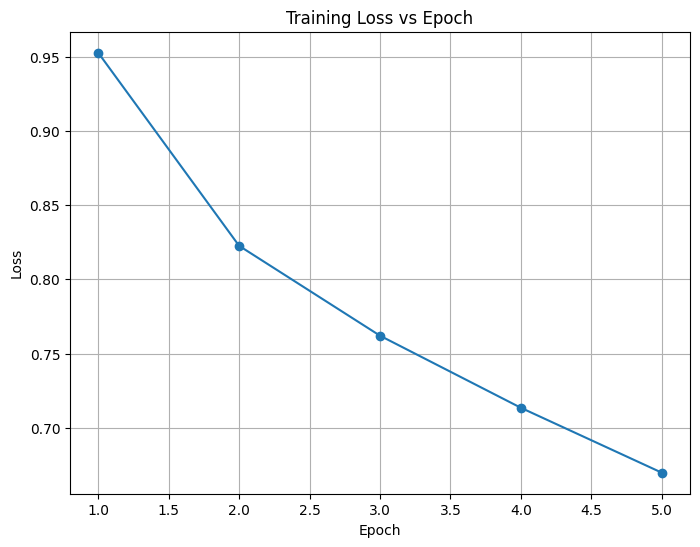

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(start_epoch + 1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
model.eval()
generated_answers = []
true_answers = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=64,
            num_beams=4,
            early_stopping=True
        )

        preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
        targets = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

        generated_answers.extend(preds)
        true_answers.extend(targets)

In [ ]:
def normalize_text(s):
    s = s.lower().strip()
    s = ''.join(ch for ch in s if ch not in string.punctuation)
    return s

def compute_f1(pred, ref):
    pred_tokens = normalize_text(pred).split()
    ref_tokens = normalize_text(ref).split()
    common = set(pred_tokens) & set(ref_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(ref_tokens)
    return 2 * (precision * recall) / (precision + recall)

def compute_rouge_l(pred, ref):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(ref, pred)
    return score['rougeL'].fmeasure

In [ ]:
f1_scores = []
rouge_l_scores = []

for pred, ref in zip(generated_answers, true_answers):
    f1_scores.append(compute_f1(pred, ref))
    rouge_l_scores.append(compute_rouge_l(pred, ref))

metrics = {
    "F1 Score": sum(f1_scores) / len(f1_scores),
    "ROUGE-L": sum(rouge_l_scores) / len(rouge_l_scores),
}

print(f"\nEvaluation Metrics:")
print(f"F1 Score: {metrics['F1 Score'] * 100:.3f}%")
print(f"ROUGE-L Score: {metrics['ROUGE-L'] * 100:.3f}%")

In [ ]:
model.eval()

print("\nAvailable judgment files:")
files = sorted([f for f in os.listdir(judgment_dir) if f.endswith('.txt')])
for f in files:
    print(f"- {f}")

while True:
    filename = input("\nEnter the filename you want to ask questions about (or type 'exit' to quit): ").strip()

    if filename.lower() == "exit":
        print("Exiting program.")
        break

    if filename not in files:
        print(f"File '{filename}' not found in the directory. Please try again.")
        continue

    context_path = os.path.join(judgment_dir, filename)
    with open(context_path, 'r', encoding='utf-8') as f:
        context = f.read()

    print(f"\nLoaded file: {filename}")
    print("You can now ask questions. Type 'exit' to choose another file or quit.")

    while True:
        question = input("\nYour Question: ").strip()
        if question.lower() == "exit":
            print("Returning to file selection.")
            break

        input_text = f"question: {question} context: {context}"
        inputs = tokenizer(
            input_text,
            return_tensors="pt",
            max_length=512,
            truncation=True,
            padding="max_length"
        ).to(device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=64,
                num_beams=4,
                early_stopping=True
            )

        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print("Answer:", answer)


Available judgment files:
- 1181.txt
- 1195.txt
- 1329.txt
- 1378.txt
- 1406.txt
- 1522.txt
- 1531.txt
- 1697.txt
- 1762.txt
- 1778.txt
- 1789.txt
- 1974.txt
- 2035.txt
- 2052.txt
- 2065.txt
- 2122.txt
- 2124.txt
- 2207.txt
- 2248.txt
- 2256.txt
- 2304.txt
- 232.txt
- 2392.txt
- 2440.txt
- 2593.txt
- 2609.txt
- 2627.txt
- 2649.txt
- 2657.txt
- 266.txt
- 2727.txt
- 2796.txt
- 2913.txt
- 3019.txt
- 314.txt
- 3168.txt
- 3210.txt
- 3292.txt
- 3356.txt
- 3436.txt
- 3442.txt
- 3531.txt
- 3542.txt
- 3602.txt
- 362.txt
- 380.txt
- 3844.txt
- 3893.txt
- 3924.txt
- 4071.txt
- 415.txt
- 4316.txt
- 4451.txt
- 4480.txt
- 4568.txt
- 4641.txt
- 4782.txt
- 4807.txt
- 4860.txt
- 4917.txt
- 4938.txt
- 496.txt
- 4963.txt
- 5141.txt
- 5142.txt
- 5248.txt
- 5266.txt
- 5364.txt
- 5397.txt
- 5471.txt
- 5538.txt
- 5597.txt
- 5707.txt
- 5861.txt
- 5888.txt
- 5937.txt
- 5994.txt
- 6003.txt
- 6118.txt
- 6157.txt
- 6245.txt
- 6270.txt
- 6276.txt
- 6413.txt
- 65.txt
- 650.txt
- 6505.txt
- 6506.txt
- 6507.txt
- 65